If you used the same basic kind of lidar as Ingenuity, with a few clever tweaks, could you profile water?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Planck's constant
h = 6.62607015e-34 # J s
c = 2.99792458e8 # m/s

# Specs on the Ingenuity lidar - https://www.garmin.com/en-US/p/557294#specs
lamb = 905e-9 # m
# power = 1.3 # W
power = 0.78 # Adjusted based on Moores's comments

energy_per_photon = h*c/lamb

# Detectors operate at kHz sampling - 
# https://www.baumer.com/us/en/product-overview/distance-measurement/laser-distance-sensors/c/289
#
# Integration time is just one pulse!
sampling_frequency = 5e3

t = 1./sampling_frequency

number_photons = power*t/energy_per_photon
print(number_photons)

710716577005679.9


Text(0, 0.5, 'Earth Extinction (1/km)')

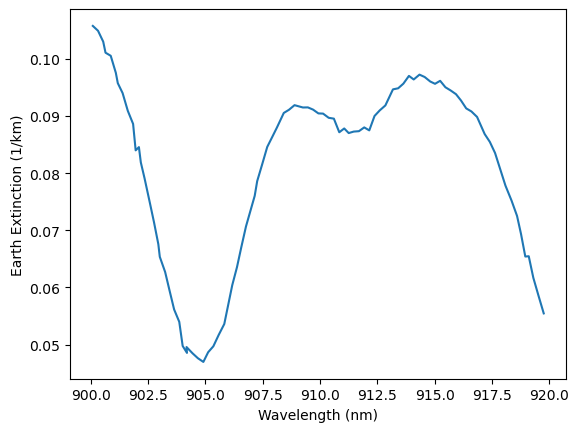

In [6]:
# 2024 Dec 12 - Trying to use Wieger & Gasteiger (2015 - https://amt.copernicus.org/articles/8/3971/2015/amt-8-3971-2015.pdf)
data = np.genfromtxt("WiegerGasteiger2015_Fig2.csv", delimiter=',', names=True)

plt.plot(data['Wavelength'], data['Extinction'])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Earth Extinction (1/km)")

Text(0, 0.5, 'Mars Extinction (1/m)')

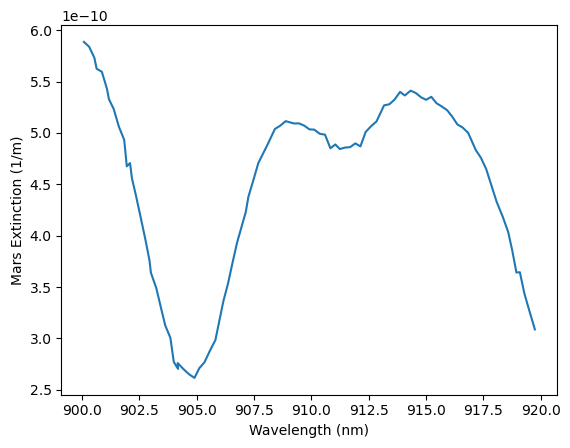

In [19]:
# Let's scale the extinction from Earth to Mars
#
# (extinction) = (atmospheric mass density)/(molecular mass) * (optical cross-section)
# -> (Mars extinction) = (Earth extinction) * (Mars atmospheric mass density)/(Earth atmospheric mass density)
#                                           * (Earth molecular mass)/(Mars molecular mass)
#                                           * (Mars water fraction)/(Earth water fraction)
#
# assuming the optical cross-section isn't too different.

Earth_density = 1.2 # kg/m^3
Mars_density = 0.02 # kg/m^3

Earth_molecular_mass = 28.946 # g/mol
Mars_molecular_mass = 43.34 # g/mol

Earth_water_fraction = 0.04
# Mars_water_fraction = 210e-6
Mars_water_fraction = 20e-6 # based on Moores's comments

# Convert from 1/km to 1/m
Mars_extinction =\
    data['Extinction']*(Mars_density/Earth_density)*\
    (Earth_molecular_mass/Mars_molecular_mass)*\
    (Mars_water_fraction/Earth_water_fraction)/1000.

plt.plot(data['Wavelength'], Mars_extinction)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mars Extinction (1/m)")

In [24]:
# At an altitude of 1 m, can we tell the difference between the total number of photons 
# in and out of the absorption band?

# Mars surface albedo - https://www.isro.gov.in/mission_global_albedo_map_of_mars.html
albedo = 0.1

path_length = 10. # m

kappa_min = np.min(Mars_extinction)
kappa_max = np.max(Mars_extinction)

inband_returned_photons = albedo*number_photons*(1. - path_length*kappa_max)
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min)

print("Difference in transmissivity: ", path_length*(kappa_max - kappa_min))

# Assuming Poisson error bars, 
# how many sigma different are the number of photons returned in and out of band?
print("Integration for one laser pulse: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

# Not even one-sigma at 10 m
# Integration for one laser pulse:  0.2643155809067568

# Lengthen integration time to 1-s
inband_returned_photons = albedo*number_photons*(1. - path_length*kappa_max)*(sampling_frequency)
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min)*(sampling_frequency)

print("Integration for 1-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))
# Integration for 1-sec:  1.3787770968677375

# Lengthen integration time to 60-s
inband_returned_photons = albedo*number_photons*(1. - path_length*kappa_max)*(sampling_frequency)*60.
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min)*(sampling_frequency)*60.

print("Integration for 60-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))
# Integration for 1-sec:  10.679961115777502

Difference in transmissivity:  3.270964704954591e-09
Integration for one laser pulse:  0.019498853084626344
Integration for 1-sec:  1.3787770968677375
Integration for 60-sec:  10.679961115777502


Some notes and websites I found useful:
* https://amt.copernicus.org/articles/8/3971/2015/amt-8-3971-2015.pdf
* https://www.garmin.com/en-US/p/557294#specs
* https://www.baumer.com/us/en/product-overview/distance-measurement/laser-distance-sensors/c/289
* https://nssdc.gsfc.nasa.gov/planetary/factsheet/marsfact.html
* https://lidar.jpl.nasa.gov/results/water_studies.php
* file:///Users/brian/Downloads/bams-1520-0477_1994_075_0975_rlpoaw_2_0_co_2.pdf
* https://www.acuitylaser.com/product/laser-sensors/long-range-sensors/ar3000-distance-measurement-sensor/
* https://arxiv.org/pdf/1109.6703
* https://opg.optica.org/oe/fulltext.cfm?uri=oe-23-17-22907&id=324519

In [18]:
# 2024 Dec 18 - Trying to use the cross-section at 822 nm from https://opg.optica.org/oe/fulltext.cfm?uri=oe-23-17-22907&id=324519

sigma = 1.24e-22/100 # cm^2 to m^2

Earth_density = 1.2 # kg/m^3
Mars_density = 0.02 # kg/m^3
CO2_molecular_mass = 1.66054e-27 # kg:

Earth_water_fraction = 0.04
Mars_water_fraction = 210e-6

Mars_water_density = Mars_density/CO2_molecular_mass*Mars_water_fraction # 1/m^3

# Mars surface albedo - https://www.isro.gov.in/mission_global_albedo_map_of_mars.html
albedo = 0.1

path_length = 10. # m

Mars_water_column_abundance = Mars_water_density*path_length*2

# Let's pretend like the dust optical depth is unity
dust_optical_depth = 1.

in_band_optical_depth = Mars_water_column_abundance*sigma
out_of_band_optical_depth = 0.

print(in_band_optical_depth)

# Let's just pretend like we can observe deep in the band and well out of the band.
inband_returned_photons = albedo*number_photons*(1. - in_band_optical_depth)
outband_returned_photons = albedo*number_photons*(1. - out_of_band_optical_depth)

# Assuming Poisson error bars, 
# how many sigma different are the number of photons returned in and out of band?
print("Integration for one laser pulse: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

print("Integration for 1-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

0.06272658291880955
Integration for one laser pulse:  379930.7042394804
Integration for 1-sec:  379930.7042394804
